### DBSCAN implementation
- build the data
- parameters: minPts, epsilon ($\epsilon$)
- define `core` points $p$ that are surrounded by at least minPts within an epsilon radius
- define `directly reachable points` $q$ from $p$ that lie within a circle of radius $\epsilon$ around $p$
- define `reacheable points` $q$ from $p$ that is points that are directly reacheable by a previous point and so on step-by-step
- define `outliers` meaning points that are no reacheable by any points

#### Build the data

In [1]:
import torch
from torch import tensor
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [4]:
torch.manual_seed(11)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [5]:
from torch.distributions import MultivariateNormal

In [6]:
n_centers = 5
n_pts = 1500
centers = torch.rand(n_centers, 2)*300-150
centers.shape, centers

(torch.Size([5, 2]),
 tensor([[-105.287,   -4.034],
         [ 145.698,  -99.480],
         [  25.183,   58.080],
         [  24.925, -111.469],
         [  21.637,  127.452]]))

In [7]:
g = MultivariateNormal(centers[0], torch.diag(tensor([5.,5.])))

In [8]:
g.sample((3,))

tensor([[-104.506,   -2.888],
        [-102.589,   -0.893],
        [-110.551,   -1.490]])

In [9]:
def generate_points(c, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [10]:
data_l = [generate_points(c,100.) for c in centers]
data = torch.cat(data_l)

In [11]:
data.shape

torch.Size([7500, 2])

In [12]:
def plot_data(centers, data_l):
    for c, dat in zip(centers, data_l):
        plt.scatter(dat[:,0], dat[:,1], s=1)
        plt.plot(*c, marker='x', markersize=10, color='k', mew=5)
        plt.plot(*c, marker='x', markersize=5, color='r', mew=1)

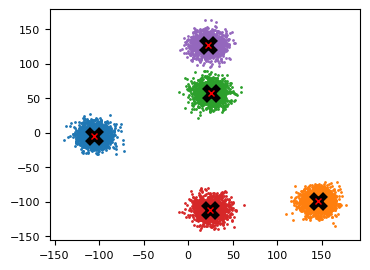

In [13]:
plot_data(centers, data_l)

#### Build the algorithm:
- for each point find the surrounding points within an $\epsilon$ radius 
- identify the core points with `num_neighbors` > `minPts`
- sort all non-core points between nearby clusters if they're within $\epsilon$ of a cluster and noise

> We can do it sequentially, point by point, and exhausting the points of a cluster to then proceed to the next cluster and end with noise points.

> We can also try to accelerate the calculation if possible. We'll try that:

In [14]:
X = data.clone()

In [15]:
X = X[torch.randperm(X.shape[0])]

In [16]:
x0 = X[0]
x1 = X[1]
(x0-X)[:3], (x1-X)[:3]

(tensor([[   0.000,    0.000],
         [-125.036,  162.456],
         [  -0.284,    6.731]]),
 tensor([[ 125.036, -162.456],
         [   0.000,    0.000],
         [ 124.752, -155.725]]))

In [17]:
X[:,None,:].shape, X.shape

(torch.Size([7500, 1, 2]), torch.Size([7500, 2]))

> Distance calculation with einsum:

In [18]:
Diff = X[:,None,:]-X
Diff[0,:3], Diff[1,:3]

(tensor([[   0.000,    0.000],
         [-125.036,  162.456],
         [  -0.284,    6.731]]),
 tensor([[ 125.036, -162.456],
         [   0.000,    0.000],
         [ 124.752, -155.725]]))

In [19]:
D = torch.einsum('ijk,ijk->ij', Diff, Diff).sqrt()
D.shape, D

(torch.Size([7500, 7500]),
 tensor([[  0.000, 205.003,   6.737,  ..., 205.918, 190.306, 185.311],
         [205.003,   0.000, 199.533,  ...,   8.269,  19.068, 136.821],
         [  6.737, 199.533,   0.000,  ..., 200.612, 184.604, 178.605],
         ...,
         [205.918,   8.269, 200.612,  ...,   0.000,  25.441, 144.476],
         [190.306,  19.068, 184.604,  ...,  25.441,   0.000, 119.664],
         [185.311, 136.821, 178.605,  ..., 144.476, 119.664,   0.000]]))

In [20]:
def distance_matrix(X): 
    Diff = X[:,None,:]-X
    return torch.sqrt(torch.einsum('ijk,ijk->ij', Diff, Diff))

> We define the DBSCAN parameters $\epsilon$ and `minPts`:

In [21]:
epsilon = 3
minPts = 20

> Now let's determine the neighbors of each point within a circle of radius $\epsilon$ :

In [22]:
def epsilon_cut(D, epsilon): return torch.where(D<epsilon, 1,0)

In [103]:
%timeit -n 3 epsilon_cut(D,epsilon)

64 ms ± 7.49 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [23]:
neighbors = epsilon_cut(D, epsilon)
neighbors

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

In [24]:
neighbors.sum()

tensor(263490)

> Core points are defined as having `minPts` neighbors:
We will need the neighbors matrix, an $n \times n$ symmtric matrix where each row $i$ corresponds to a binary vector indicating if point $x_i$ is neighbor with points $x_j$, $j \in n$  

In [25]:
def core_pts_calc(D, epsilon, minPts):
    neighbors = epsilon_cut(D, epsilon)
    return neighbors, torch.where(neighbors.sum(1)>=minPts, 1,0)

In [26]:
neighbors, core_bool = core_pts_calc(D, epsilon, minPts)

In [27]:
core_bool.shape, neighbors.shape

(torch.Size([7500]), torch.Size([7500, 7500]))

In [28]:
X.shape

torch.Size([7500, 2])

In [86]:
%timeit -n 30 X_c = X[core_bool==1]

103 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [87]:
%timeit -n 30 X*core_bool[:,None]

53.1 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [29]:
def plot_core(X, core_bool):
    X_c = X[core_bool==1]
    X_nc = X[core_bool==0]
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(X_c[:,0], X_c[:,1], s=1)
    ax.scatter(X_nc[:,0], X_nc[:,1], s=1)
#     c = plt.Circle((-35.5, 49), 2, color='k', fill=False)
#     ax.add_patch(c)

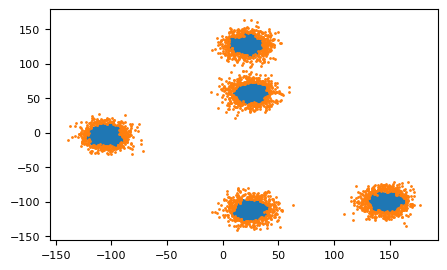

In [30]:
plot_core(X, core_bool)

 Now let's build the cluster search algorithm, the steps are as follow:

>- initialize a cluster vector of length n_points  $-$  initialize at 0 ($\equiv$ belongs to no cluster)
>- get the neighbors matrix
>- get the neighbor matrix of only the core points
>- go through the core points 
    - verify if any of the neighbors already has a cluster value 
    - assign all neighbors to the same cluster value: either the min cluster value found among the neighbors or a new one if all neighbors are assigned to cluster 0.
    - in case neighbor points are already assigned, record their previous cluster values and assign all the points that share these cluster numbers to the same min value obtained above. This will prevent small artefact clusters or points to remain mis-clustered next to a larger cluster because they were assigned at different moments in the loop. Scikit-learn implementation does no check that and sometimes some artefact clusters appear in their cluster predictions (we'll see an exemple of that later). 

> We'll need to use a reverse function to find the indexes at which the vector has a given value, we can use `torch.where` or `(tensor_0 == x).nonzero()`: <br>
*However we should replace all .nonzero() by torch.where() when using CUDA to avoid a slow down due to CPU synchronization, see [here](https://pytorch.org/docs/stable/generated/torch.nonzero.html#torch.nonzero).*

In [31]:
torch.where(core_bool==1)[0]

tensor([   0,    1,    2,  ..., 7497, 7498, 7499])

In [32]:
torch.where(core_bool)[0]

tensor([   0,    1,    2,  ..., 7497, 7498, 7499])

In [33]:
core_bool.nonzero().squeeze()

tensor([   0,    1,    2,  ..., 7497, 7498, 7499])

In [33]:
%timeit -n 1000 torch.where(core_bool==0)[0]

45.3 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
%timeit -n 1000 core_bool.nonzero().squeeze()

40.1 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
%timeit -n 1000 (core_bool==0).nonzero().squeeze()

44.9 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


> We initialize the cluster vector and build the cluster search loop trying to keep as much as possible vectorial calculations:

In [34]:
cluster = torch.zeros(X.shape[0])

In [35]:
core_n_idx = core_bool.nonzero().squeeze()
neighbors.shape, core_n_idx.shape

(torch.Size([7500, 7500]), torch.Size([5435]))

In [36]:
neighbors[core_n_idx].shape

torch.Size([5435, 7500])

In [39]:
%timeit -n 5 neighbors[core_n_idx][0].nonzero().squeeze()

47.1 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


> In the outer loop we go through all the core points neighbors matrix, in the inner loop we verify if the neighbors have already a value assigned to them. If they do, the idea is to find the smaller cluster value present and assign it to all of them (as they are all neighbors to a core point they are part of the same cluster). A second check is performed to assign all the other points that share these cluster values to the same min value selected above.<br>
This step is costly, we can implement it with an index search via torch.isin() or by a loop through the cluster values of the neighbors. The for loop is quite faster.

In [37]:
i = 1
for u in neighbors[core_n_idx]:
    u_idx = u.nonzero().squeeze()
#     u_idx = torch.where(u)[0]
    if cluster[u_idx].sum() > 0:
        nn_idx = u_idx[cluster[u_idx].nonzero().squeeze()] # nearest neighbors indexes that already have a non-zero cluster value
#         nn_idx = u_idx[torch.where(cluster[u_idx])[0]]
        c_num = cluster[nn_idx].min()                      # cluster number
#         all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze()
#         cluster[all_n_idx] = c_num
        for n in cluster[nn_idx].unique():
            idx = (cluster==n).nonzero().squeeze()
#             idx = torch.where(cluster==n)[0] 
            cluster[idx] = c_num
        cluster[u_idx] = c_num
    else:
        cluster[u_idx] = i
        i += 1

In [38]:
torch.unique(cluster)

tensor([0., 1., 2., 5., 6., 7.])

> `torch.isin` is very slow, it is faster to perform a for loop in python, so we replace this part:

```python
all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze()
cluster[all_n_idx] = c_num
```
>by this:

```python
for n in cluster[nn_idx].unique():
    idx = (cluster==n).nonzero().squeeze()
    cluster[idx] = c_num
    cluster[u_idx] = c_num
```

> see the comparison below:

In [150]:
%%timeit -n 2
D = distance_matrix(X)
neighbors, core_bool = core_pts_calc(D, epsilon, minPts)
core_n_idx = core_bool.nonzero().squeeze()
cluster = torch.zeros(X.shape[0])

i = 1
for u in neighbors[core_n_idx]:
    u_idx = u.nonzero().squeeze()
    if cluster[u_idx].sum() > 0:
        nn_idx = u_idx[cluster[u_idx].nonzero().squeeze()]                   # nearest neighbors indexes that already have a non-zero cluster value
        c_num = cluster[nn_idx].min()                                        # smallest cluster number
        all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze() # all points that share a common cluster number with the nearest neighbors (sub graph)
        cluster[all_n_idx] = c_num
#         for n in cluster[nn_idx].unique():
#             idx = (cluster==n).nonzero().squeeze()
#             cluster[idx] = c_num
#         cluster[u_idx] = c_num
    else:
        cluster[u_idx] = i
        i += 1

2.63 s ± 255 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [149]:
%%timeit -n 2
D = distance_matrix(X)
neighbors, core_bool = core_pts_calc(D, epsilon, minPts)
core_n_idx = core_bool.nonzero().squeeze()
cluster = torch.zeros(X.shape[0])

i = 1
for u in neighbors[core_n_idx]:
    u_idx = u.nonzero().squeeze()
    if cluster[u_idx].sum() > 0:
        nn_idx = u_idx[cluster[u_idx].nonzero().squeeze()]                   # nearest neighbors indexes that already have a non-zero cluster value
        c_num = cluster[nn_idx].min()                                        # smallest cluster number
#         all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze() # all points that share a common cluster number with the nearest neighbors (sub graph)
#         cluster[all_n_idx] = c_num
        for n in cluster[nn_idx].unique():
            idx = (cluster==n).nonzero().squeeze()
            cluster[idx] = c_num
        cluster[u_idx] = c_num
    else:
        cluster[u_idx] = i
        i += 1

1.4 s ± 348 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


> Let's wrap up these steps in a function `dbscan` and plot the clusters:

In [39]:
def plot_clusters(X, clusters):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(X[:,0], X[:,1], s=1, c=clusters)

In [40]:
def find_c(neighbors, core_bool):
    clusters = torch.zeros(core_bool.shape)
    core_n_idx = torch.where(core_bool)[0]
    i = 1
    for u in neighbors[core_n_idx]:
        u_idx = torch.where(u)[0]
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            clusters[u_idx] = i
            i += 1
    return clusters

In [41]:
def dbscan(data, eps, minPts, plot=False):
    X = data.clone()
    D = distance_matrix(X)
    neighbors, core_bool = core_pts_calc(D, eps, minPts)
    clust = find_c(neighbors, core_bool)
    if plot: plot_clusters(X, clust)
    return clust

> We can implement a fast version of the find_cluster function by removing the neighbors search when the core opint was already 

In [42]:
def find_c_fast(neighbors, core_bool):
    clusters = torch.zeros(core_bool.shape)
    core_n_idx = torch.where(core_bool)[0]
    core_done = torch.tensor([-1]) # just to initialize the tensor
    i = 1
    for k in core_n_idx:
        if k in core_done: continue
        u = neighbors[k]
        u_idx = torch.where(u)[0]
        core_done = torch.cat((core_done,u_idx))
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            clusters[u_idx] = i
            i += 1
    return clusters

In [43]:
def dbscan_fast(data, eps, minPts, plot=False):
    X = data.clone()
    D = distance_matrix(X)
    neighbors, core_bool = core_pts_calc(D, eps, minPts)
    clust = find_c_fast(neighbors, core_bool)
    if plot: plot_clusters(X, clust)
    return clust

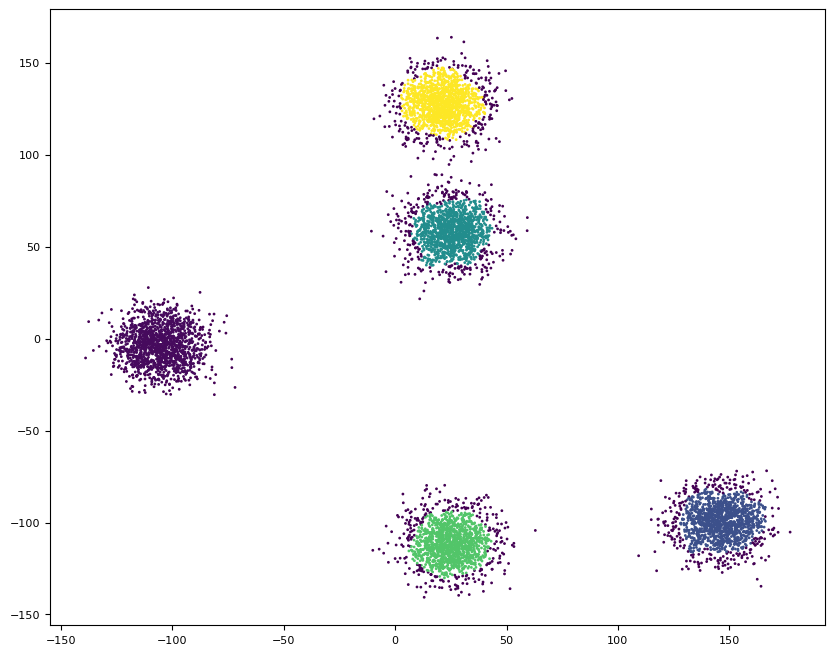

In [58]:
cl = dbscan(data, 3, 20, plot=True)

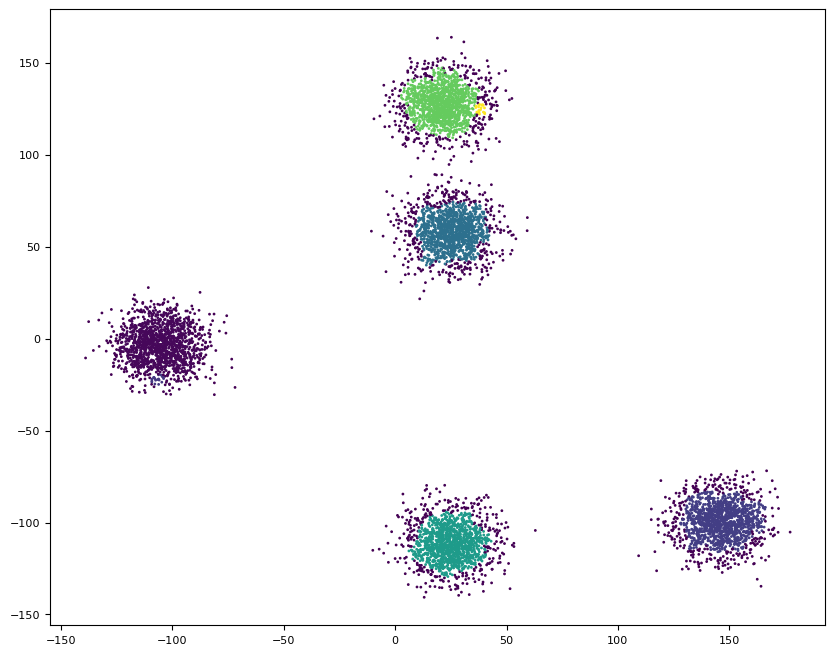

In [59]:
cl = dbscan_fast(data, 3, 20, plot=True)

In [60]:
cl.unique()

tensor([ 0.,  1.,  9., 10., 20., 30., 42., 55.])

With the fast version, we obtain a better performance but some artefact clusters appear similarly to the sklearn implementation. It is due to the possibility for points to be labellized as already assigned that will never overlap with another core point neighborhood for $\epsilon$ small enough.

In [977]:
%timeit -n 2 _ = dbscan(data,3,20)

1.11 s ± 73.1 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [999]:
%timeit -n 2 _ = dbscan_fast(data,3,20)

455 ms ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


>Let's compare with the scikit-learn implementation of DBSCAN:

In [47]:
from sklearn.cluster import DBSCAN

In [48]:
y_pred = DBSCAN(eps=3, min_samples=20).fit_predict(X)

In [49]:
%timeit -n 2 y_pred = DBSCAN(eps=3, min_samples=20).fit_predict(X)

35.8 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


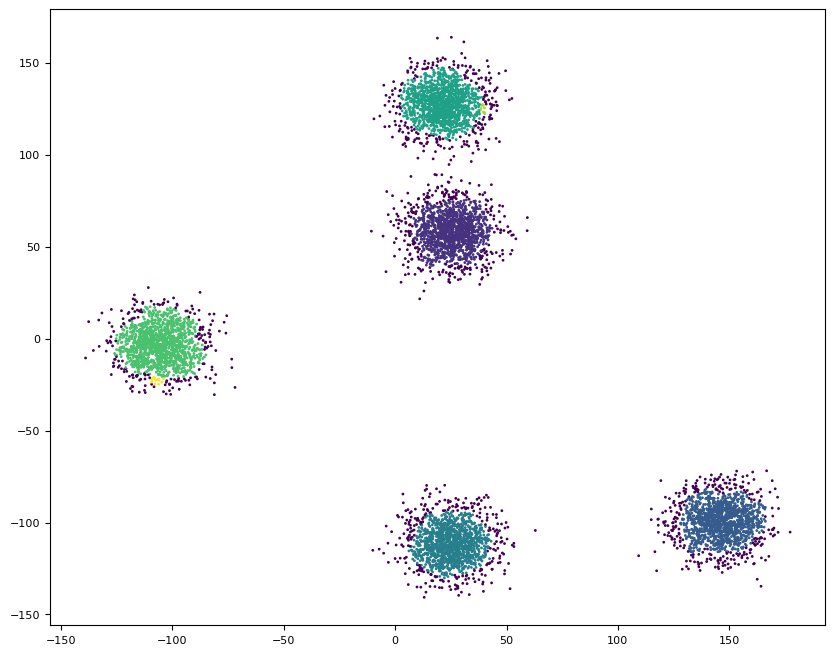

In [50]:
plot_clusters(X, y_pred)

We can see that there are some islands of residual clusters in the middle of larger clusters. They likely do not check for all the core points that were assigned to another cluster earlier on and not converted to their final cluster, resulting in artefacts.

Our implementation yields more accurate results than sklearn's DBSCAN(in cython) but at the same time is **30x** slower. We could possibly fasten it by using GPU acceleration.

### Using Rtrees and Local Sensitive Hashing

We'll modify a bit the functions, we'll need to:
- define a iterator for the data to quickly create the index graph
- create a table of only the `minPts` nearest neighbors with index.Index().nearest()
- build the distance matrix of dims (N, minPts)
- another possibility is to create a circle object of radius $\epsilon$ around each point and use thin index.Index().interesect method or rtrees.


#### RTrees

In [58]:
from rtree import index

In [59]:
class idx_format():
    def __init__(self, X):
        self.X = X
        self.step = 0
        self.max_step = X.shape[0]
    def __iter__(self): return self
    def __next__(self):
        if self.step >= self.max_step: raise StopIteration
        pt = (self.step, (*self.X[self.step], *self.X[self.step]), None)
        self.step += 1
        return pt

In [60]:
X = data.clone()

In [61]:
X_it = iter(idx_format(X))
idx = index.Index(list(X_it))

In [63]:
def distance_matrix(X): 
    Diff = X[:,None,:]-X
    return torch.sqrt(torch.einsum('ijk,ijk->ij', Diff, Diff))

In [64]:
def epsilon_cut(D, epsilon): return torch.where(D<epsilon, 1,0)

In [65]:
def core_pts_calc(D, epsilon): return torch.where(epsilon_cut(D, epsilon).sum(1)>=minPts, 1,0)

In [66]:
neighbors.shape

torch.Size([7500, 7500])

In [67]:
def NN_matrix(X, idx, k):
#     X_nn = torch.zeros(X.shape[0], k, 2)
    for i in range(X.shape[0]):
        idxnn = list(idx.nearest(X[i], k))
#         X_nn[i] = X[idxnn][:k]
#     return X_nn

In [78]:
%timeit -n 2 NN_matrix(X, idx, minPts)

1.21 s ± 7.61 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [74]:
%%timeit -n 2
D = distance_matrix(X)
core_bool = core_pts_calc(D, epsilon)
core_n_idx = core_bool.nonzero().squeeze()
neighbors = epsilon_cut(D, epsilon)
cluster = torch.zeros(X.shape[0])

427 ms ± 50 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


Way too slow for this use as built here.

#### Locality-Sensitive Hashing

In [61]:
n_centers = 5
n_pts = 500
centers = torch.rand(n_centers, 2)*60-30
centers.shape, centers

(torch.Size([5, 2]),
 tensor([[-29.232,  29.772],
         [-16.721,  -3.138],
         [ 23.530, -11.880],
         [ 20.444,  24.361],
         [-15.630, -28.652]]))

In [62]:
def generate_points(c, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [63]:
dat_l = [generate_points(c,5.) for c in centers]
dat = torch.cat(dat_l)

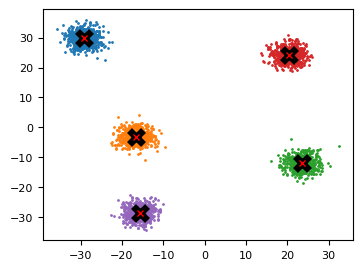

In [64]:
plot_data(centers,dat_l)

tensor([0., 1., 2., 3., 4., 5.])

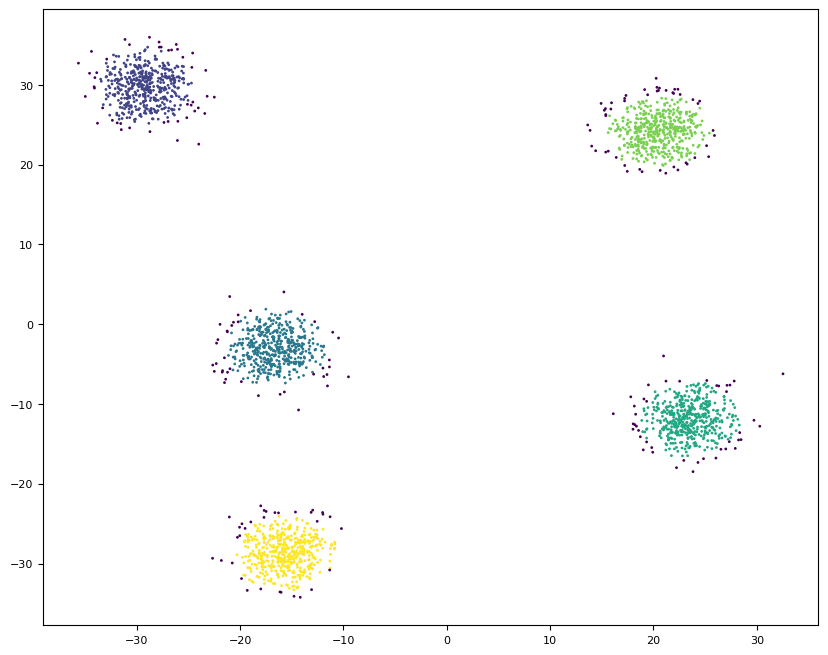

In [67]:
dbscan(dat, 2, 80, plot=True).unique()

In [68]:
X = dat.clone()

We can use the Data_hash class we developed in the LSH notebook:

In [69]:
class Data_hash():
    def __init__(self, data, dim, n_hash, scale_factor=1): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        h_t = 2*torch.pi*torch.rand(n_hash)
        self.h_mat = torch.stack([torch.cos(h_t), -torch.sin(h_t)])
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        
    def _hash(self, X): return torch.floor(X @ self.h_mat * self.s + self.h_b)
    
    def find_nns(self, x, n_matches): 
        v_collide = (self._hash(x) == self.hashed).sum(1)
        nns = torch.where(v_collide > n_matches)[0]
        return v_collide, nns 
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-2,3):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))*self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.2, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [70]:
# Hash the data
X_hash = Data_hash(X, X.shape[1], 20, scale_factor=0.7)
X_hash.hashed.shape

torch.Size([2500, 20])

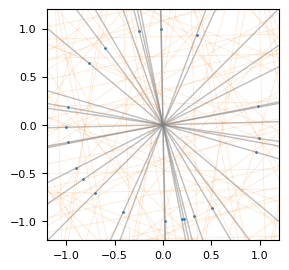

In [71]:
# Plot the hash directions and hash lines
X_hash.plot_hd()

In [72]:
# Pick a random point
pt = X[torch.randint(X.shape[0],(1,))][0]

In [73]:
# Generate its nearest neighbors
_, ref_nns = X_hash.find_nns(pt,5)

In [74]:
X_hash._hash(pt).shape, (X_hash._hash(pt)==X_hash.hashed).shape

(torch.Size([20]), torch.Size([2500, 20]))

In [75]:
ref_nns

tensor([2001, 2008, 2015, 2019, 2021, 2036, 2038, 2042, 2047, 2049, 2051, 2058, 2060, 2062, 2063, 2070, 2071, 2074, 2077, 2078, 2082, 2090,
        2091, 2095, 2100, 2104, 2108, 2110, 2111, 2112, 2115, 2116, 2117, 2119, 2123, 2125, 2129, 2130, 2141, 2142, 2144, 2148, 2150, 2153,
        2155, 2160, 2162, 2166, 2167, 2168, 2170, 2171, 2172, 2173, 2175, 2181, 2182, 2183, 2186, 2189, 2194, 2196, 2203, 2205, 2212, 2214,
        2216, 2222, 2228, 2236, 2237, 2238, 2244, 2249, 2251, 2259, 2260, 2262, 2269, 2270, 2272, 2276, 2281, 2283, 2286, 2290, 2292, 2293,
        2294, 2299, 2302, 2304, 2309, 2310, 2312, 2313, 2314, 2319, 2320, 2323, 2325, 2327, 2330, 2331, 2332, 2335, 2340, 2342, 2347, 2349,
        2353, 2358, 2362, 2365, 2367, 2370, 2373, 2375, 2377, 2379, 2383, 2388, 2390, 2394, 2397, 2401, 2405, 2412, 2413, 2416, 2417, 2419,
        2422, 2424, 2425, 2429, 2430, 2431, 2433, 2438, 2442, 2444, 2446, 2449, 2454, 2463, 2464, 2467, 2470, 2476, 2478, 2481, 2482, 2485,
        2489, 2496])

In [76]:
X_hash.hashed[:,None,:].shape, X_hash.hashed.shape

(torch.Size([2500, 1, 20]), torch.Size([2500, 20]))

We can compare every point's hash with the others so:

In [77]:
# Boolean symmetric n x n matrix of hash similarity between all points
%timeit -n 2 nns_bool = (X_hash.hashed[:,None,:] == X_hash.hashed)

35.4 ms ± 7.39 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [79]:
nns_bool = (X_hash.hashed[:,None,:] == X_hash.hashed)
nns_bool.shape

torch.Size([2500, 2500, 20])

However the calculation can get very large and breaks even for a rather small number of points. <br>
>We can try the cosine similarity $\frac{A\cdot B}{\lVert A\rVert \times \lVert B\rVert}$ :

Here the normalizing factor $\lVert A\rVert \times \lVert B\rVert$ is the diagonal of the matrix.

In [80]:
simX_hash.hashed @ X_hash.hashed.transpose(0,1)
(X_hash.hashed @ X_hash.hashed.transpose(0,1))[:3]

tensor([[ 7030.,  7401.,  8096.,  ..., -2562., -1765., -2437.],
        [ 7401.,  7813.,  8517.,  ..., -3002., -2129., -2847.],
        [ 8096.,  8517.,  9330.,  ..., -2824., -1920., -2689.]])

In [81]:
%timeit -n 30 X_hash.hashed @ X_hash.hashed.transpose(0,1)

2.82 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [98]:
sim_mat.diagonal(0)

The slowest run took 32.56 times longer than the fastest. This could mean that an intermediate result is being cached.
7.75 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [84]:
%timeit -n 30 torch.einsum('ij,kj->ik',X_hash.hashed,X_hash.hashed)

2.95 ms ± 827 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [101]:
sim_mat = X_hash.hashed @ X_hash.hashed.transpose(0,1)
sim_mat /= sim_mat.diagonal(0)
sim_mat

tensor([[     1.000,      0.947,      0.868,  ...,     -0.426,     -0.395,     -0.469],
        [  7401.000,      1.000,      0.913,  ...,     -0.499,     -0.476,     -0.548],
        [  8096.000,   8517.000,      1.000,  ...,     -0.470,     -0.430,     -0.518],
        ...,
        [ -2562.000,  -3002.000,  -2824.000,  ...,      1.000,      1.156,      1.075],
        [ -1765.000,  -2129.000,  -1920.000,  ...,   5164.000,      1.000,      0.923],
        [ -2437.000,  -2847.000,  -2689.000,  ...,   5587.000,   4795.000,      1.000]])

Now we can calculate the matrix of nearest neighbors, let's verify: 
- first if it is a fast calculation
- second if adding the epsilon cuttof and thus the distance calculation is still interesting performance wise (for meanshift, we can just use these approximate nearest neighbors to calculate each new point position)

> We'll need both a '**radius**' and  number of points to define core points. <br>
 We need to set a `minPts` parameter and $\epsilon$ is replaced here by the `n_match` parameter, which gives a sense of locality but much looser than the real $\epsilon$ of DBSCAN. Let's see how it performs. 


In [1045]:
n_match = 7
minPts = 50

In [1046]:
nns_mat = torch.where(nns_bool.sum(2)>=n_match, 1,0)
nns_mat.shape

torch.Size([2500, 2500])

In [1047]:
# Core point calculation
core_bool = nns_mat.sum(1)>minPts

In [1048]:
#indexes of the core points
cb_idx = torch.where(core_bool)[0]
core_bool.sum(), cb_idx.shape

(tensor(1691), torch.Size([1691]))

In [1049]:
def nns_matrix(X_hash, n_match, minPts):
    nns_bool = (X_hash.hashed[:,None,:] == X_hash.hashed)
    nns_mat = torch.where(nns_bool.sum(2)>=n_match, 1,0)
    core_bool = nns_mat.sum(1)>minPts
    return nns_mat, core_bool

In [1050]:
# nearest neighbors list function of n_match
nn_num = []
for i in range(n_hashes):
    nn_num.append(torch.where(nns_bool.sum(2)>=i, 1,0).sum(1).tolist())

In [1051]:
# list of nearest neighbors for 0 <= n_match <= n_hash
nn_num = []
for i in range(X_hash.n_h):
    nn_num.append(torch.where(nns_bool[cb_idx].sum(2)>=i, 1,0).sum(1).tolist())

In [1052]:
torch.tensor(nn_num).shape, torch.tensor(nn_num)

(torch.Size([20, 1691]),
 tensor([[2500, 2500, 2500,  ..., 2500, 2500, 2500],
         [1323, 1168, 1321,  ...,  775,  758,  780],
         [ 743,  724,  626,  ...,  407,  411,  434],
         ...,
         [  10,    8,    6,  ...,   12,    6,   14],
         [   9,    4,    4,  ...,   10,    4,   11],
         [   5,    4,    3,  ...,    8,    3,    2]]))

In [1053]:
torch.tensor(nn_num)[1].min()

tensor(573)

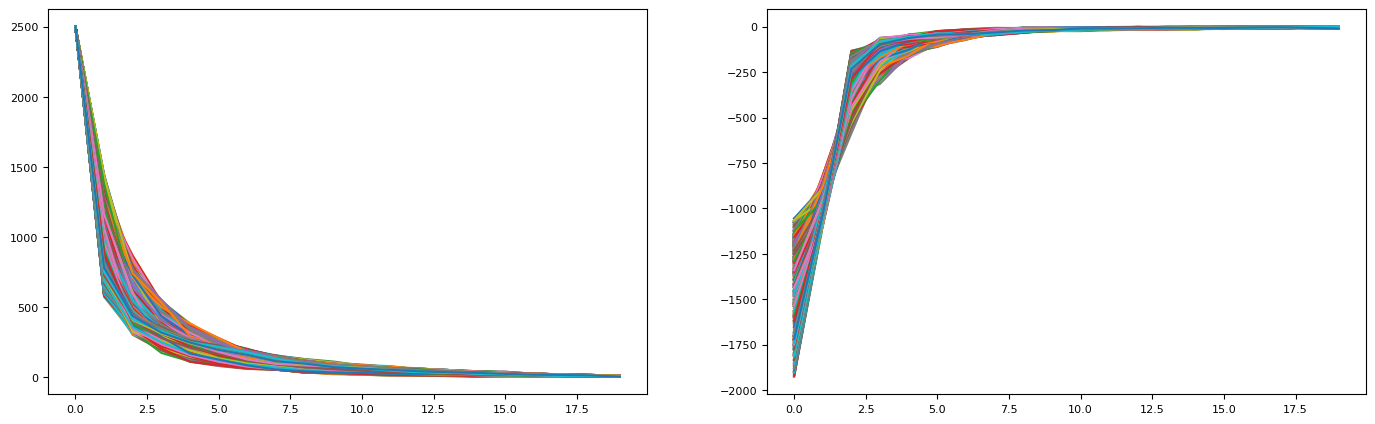

In [1054]:
fig, axs = plt.subplots(1, 2, figsize=(17,5))
for u in torch.tensor(nn_num).transpose(0,1):
    axs[0].plot(u)
    axs[1].plot(torch.gradient(u)[0])

In [1073]:
def dbscan_lsh(data, n_hash, n_match, minPts, s, plot=False):
    X = data.clone()
    X_hash = Data_hash(X, X.shape[1], n_hash, scale_factor=s)
    nns_mat, core_bool = nns_matrix(X_hash,n_match, minPts)
    clust = find_c_fast(nns_mat, core_bool)
    if plot: plot_clusters(X, clust)
    return clust

tensor([ 0.,  1.,  6.,  8., 10.])

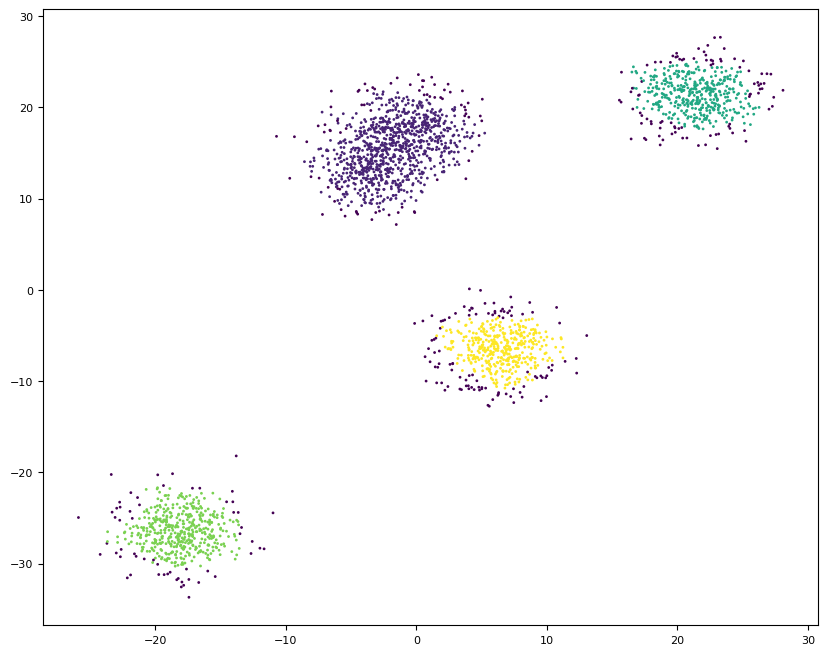

In [1068]:
cl = dbscan_lsh(dat, 11, 5, 35, 0.7, plot=True)
cl.unique()

In [1058]:
%timeit -n 2 _ = dbscan_fast(dat,2,70)

74.4 ms ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [1070]:
%timeit -n 2 _ = dbscan(dat,2,70)

264 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [1074]:
%timeit -n 2 _ = dbscan_lsh(dat, 11, 5, 35, 0.7)

152 ms ± 8.98 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


tensor([0., 1., 2., 4., 5.])

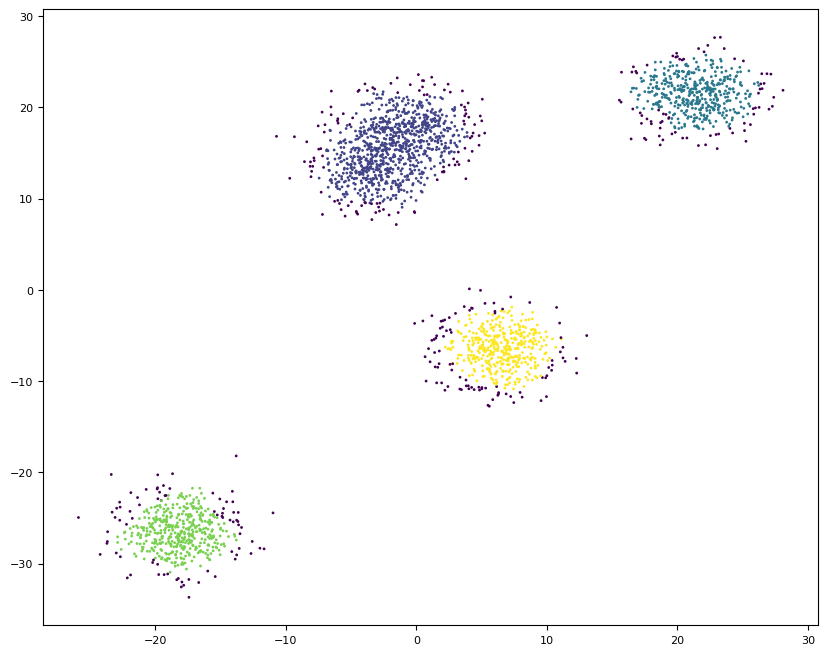

In [1061]:
dbscan_fast(dat,2,70, plot=True).unique()

The point of LSH is to get the nearest neighbors without calculating the distances. <br>
We could think of an algorithm that groups points together based on hash similarity.. <br>

In [382]:
def plot_nns(pt, nns, X, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,8))
    for k in X[nns]:
        ax.plot(*torch.stack([pt, k]).transpose(0,1),
                alpha=0.2,
                color="C0")
    ax.scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
    ax.scatter(*pt.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)
#     ax.set_xlim(25, 35)
#     ax.set_ylim(-15, -25);

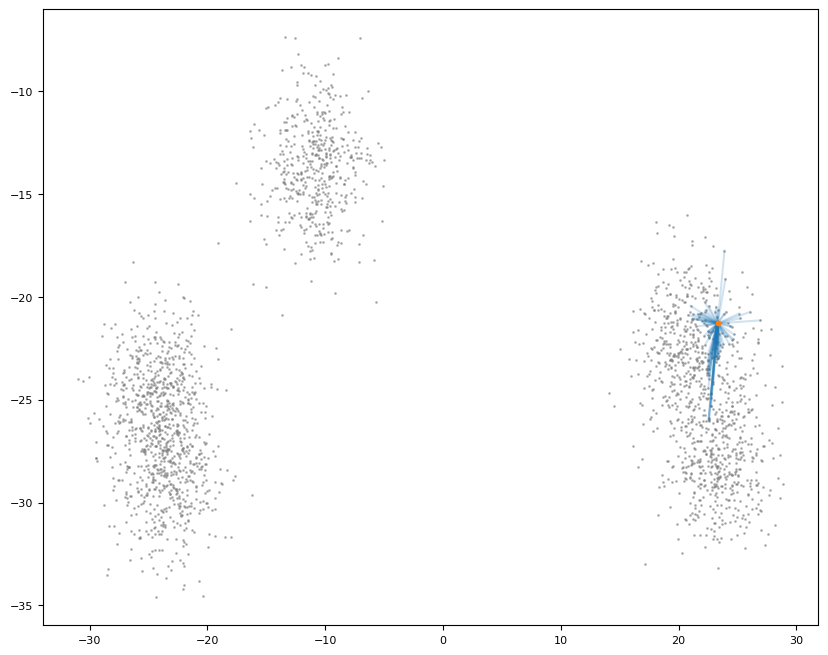

In [799]:
plot_nns(pt, ref_nns, X)

In [563]:
class Data_hash_():
    def __init__(self, data, dim, n_hash, scale_factor=1): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        self.h_mat = torch.rand((dim,n_hash))
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        
    def _hash(self, X): return torch.floor(torch.stack((X[:,0]**2, X[:,0],X[:,1]),dim=1) @ self.h_mat * self.s + self.h_b)
    
    def find_nns(self, x, n_matches): 
        v_collide = (self._hash(x) == self.hashed).sum(1)
        nns = torch.where(v_collide > n_matches)[0]
        return v_collide, nns 
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-2,3):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))*self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.2, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [572]:
modX = Data_hash_(X,3,10,scale_factor=0.1)

In [573]:
x = X[torch.randint(X.shape[0],(1,))]

In [576]:
_, rf_nns = modX.find_nns(x, 0)

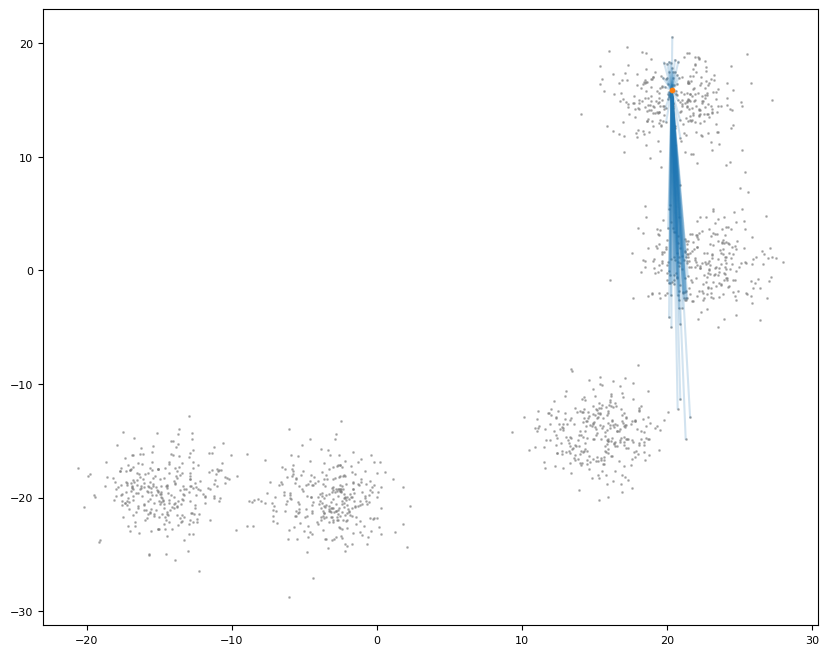

In [577]:
plot_nns(x[0], rf_nns, X)